# Multas de tránsito en USA

Las infracciones de tráfico siguieron a la invención del automóvil: la primera multa de tráfico en los Estados Unidos supuestamente se le dio a un taxista de la ciudad de Nueva York el 20 de mayo de 1899 por ir a la vertiginosa velocidad de 12 millas por hora (aprox. 19.3 km/h). Desde entonces, se han emitido innumerables citaciones por infracciones de tránsito en todo el país, y los estados han cosechado miles de millones de dólares en ingresos de los infractores.

Las infracciones de tránsito generalmente se dividen en tipos de infracciones mayores y menores. El tipo más leve son las infracciones de estacionamiento, que no se cuentan en el historial de manejo, aunque una persona puede ser arrestada por infracciones no pagadas.

El tipo más común de infracción de tránsito es la infracción del límite de velocidad. Los límites de velocidad están definidos por estado.

El dataset fue obtenido de Kaggle: https://www.kaggle.com/datasets/felix4guti/traffic-violations-in-usa

In [16]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
matplotlib.rcParams['figure.figsize'] = [16,5]
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### 1. Graficar una serie a partir de un dataset relevante. Describir observaciones.

In [17]:
# Carga del dataset
inputfile="Traffic_Violations.csv"
print('Input file is:', inputfile)
df = pd.read_csv(inputfile)
df = df.rename(columns={'Date Of Stop': 'fecha_detencion'})
df = df.set_index(pd.DatetimeIndex(df['fecha_detencion']))
df.sort_index(ascending=True, inplace=True)
df["Count"] = 1
df = df["Count"]

df = df.groupby("fecha_detencion").count()
# Informacion general
df.info()


Input file is: Traffic_Violations.csv
<class 'pandas.core.series.Series'>
DatetimeIndex: 1822 entries, 2012-01-01 to 2016-12-27
Series name: Count
Non-Null Count  Dtype
--------------  -----
1822 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


In [18]:
df.describe().round(2)

count    1822.00
mean      559.07
std       194.64
min        10.00
25%       420.00
50%       545.00
75%       686.00
max      1281.00
Name: Count, dtype: float64

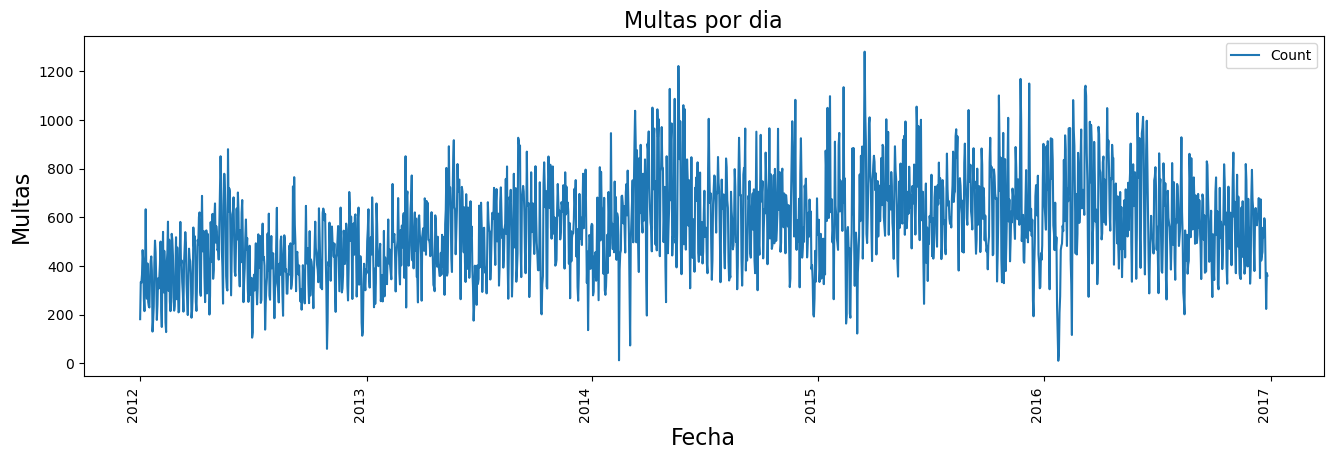

In [19]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df.plot(y='Count', rot=90)
ax.set_title("Multas por dia", fontsize=16)
ax.set_ylabel("Multas", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

#### Observaciones.

Se puede ver que la serie presenta cierta estabilidad en la cantidad de multas que se realizaron a través de los años 2012 y 2017, teniendo en cuenta los picos que se dieron en ciertas ocasiones. Estos picos alcanzan mínimos de 10 multas y máximos de 1281 multas en un dia. A simple vista se puede inferir que la serie tiene una estacionalidad del tipo anual.

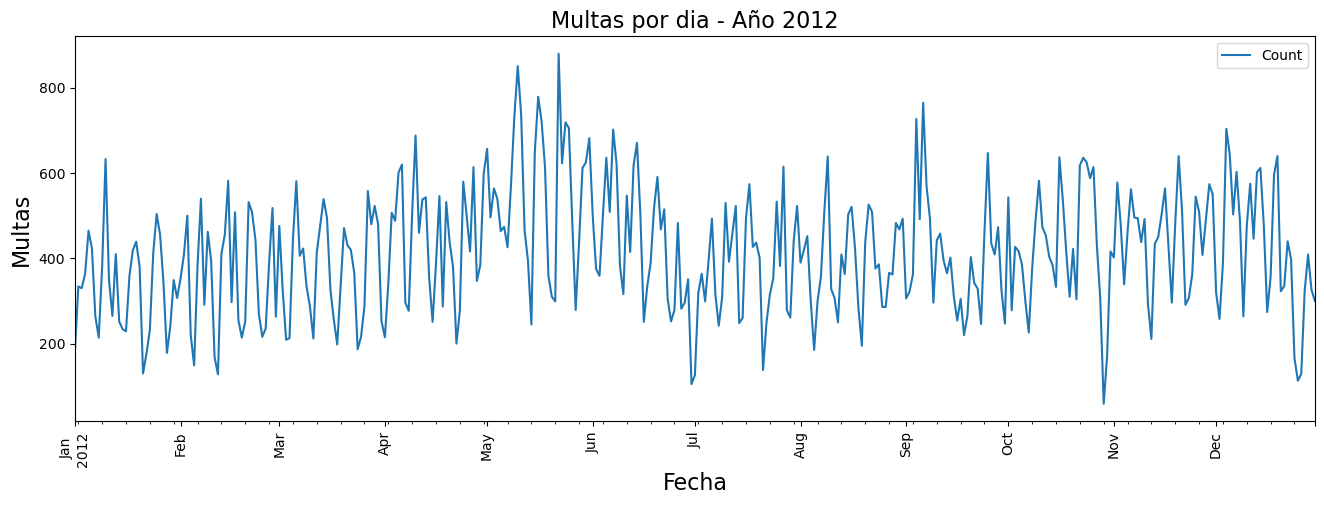

In [20]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df[:365].plot(y='Count', rot=90)
ax.set_title("Multas por dia - Año 2012", fontsize=16)
ax.set_ylabel("Multas", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

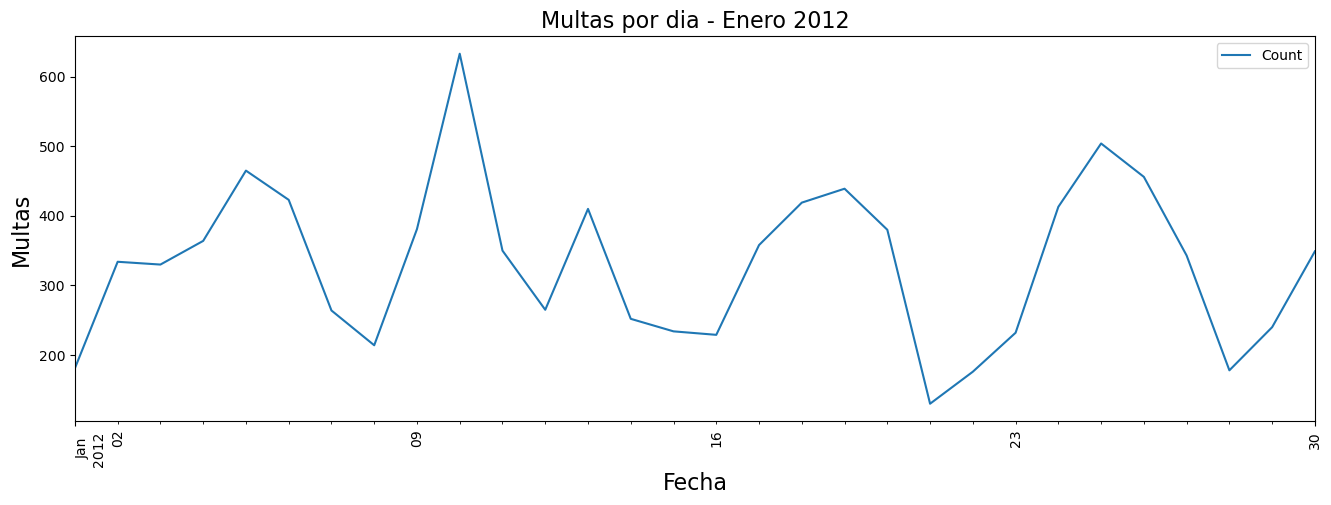

In [21]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df[:30].plot(y='Count', rot=90)
ax.set_title("Multas por dia - Enero 2012", fontsize=16)
ax.set_ylabel("Multas", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)

plt.legend(loc='best')
plt.show()

### Descomponer una serie de tiempo usando el modelo aditivo de cuatro componentes

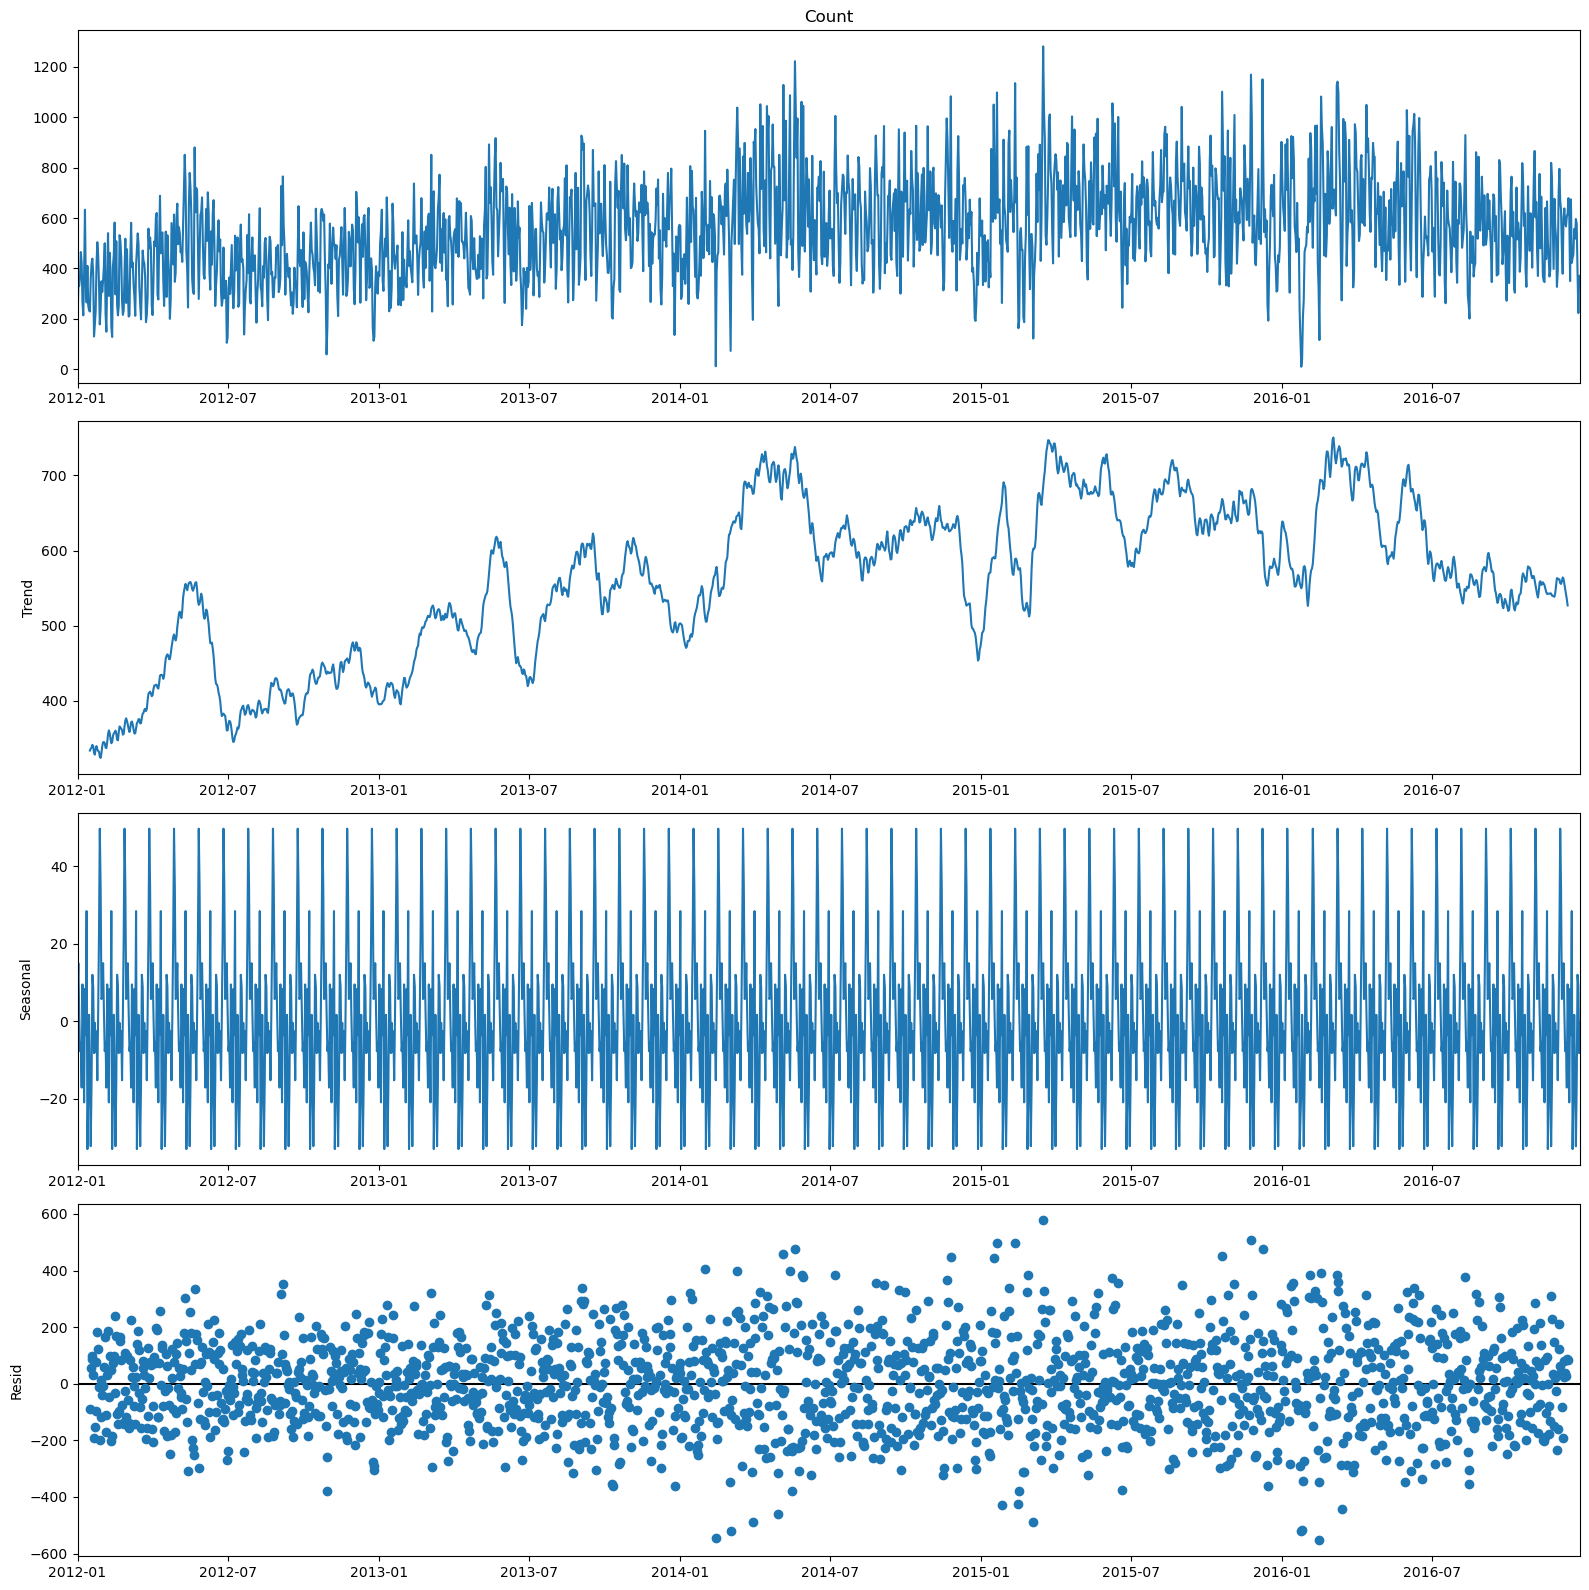

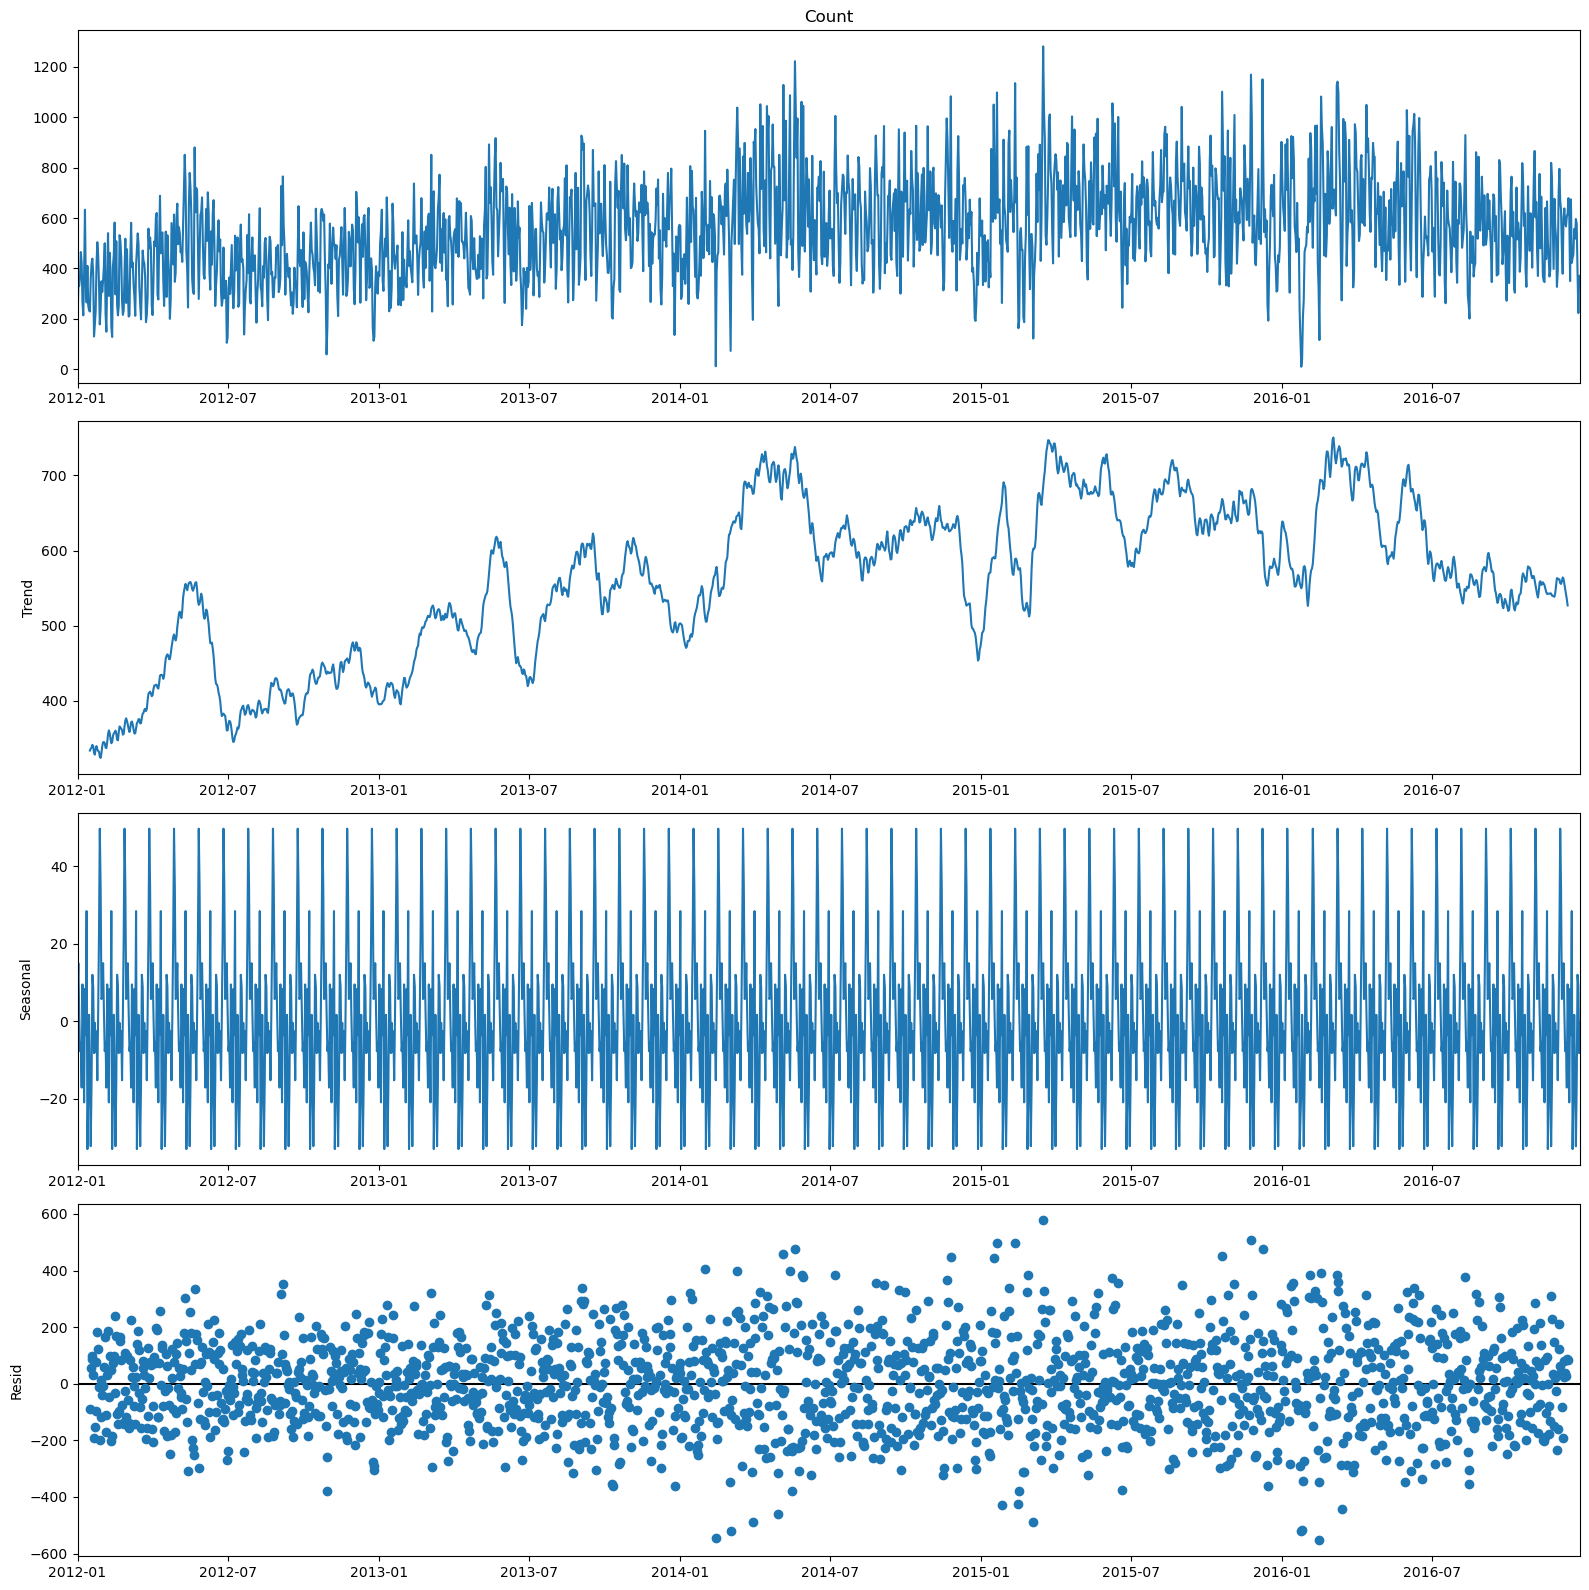

In [22]:
period= 30

matplotlib.rcParams['figure.figsize'] = [16,16]

addit = sm.tsa.seasonal_decompose(df, model='additive', period=period)
addit.plot()

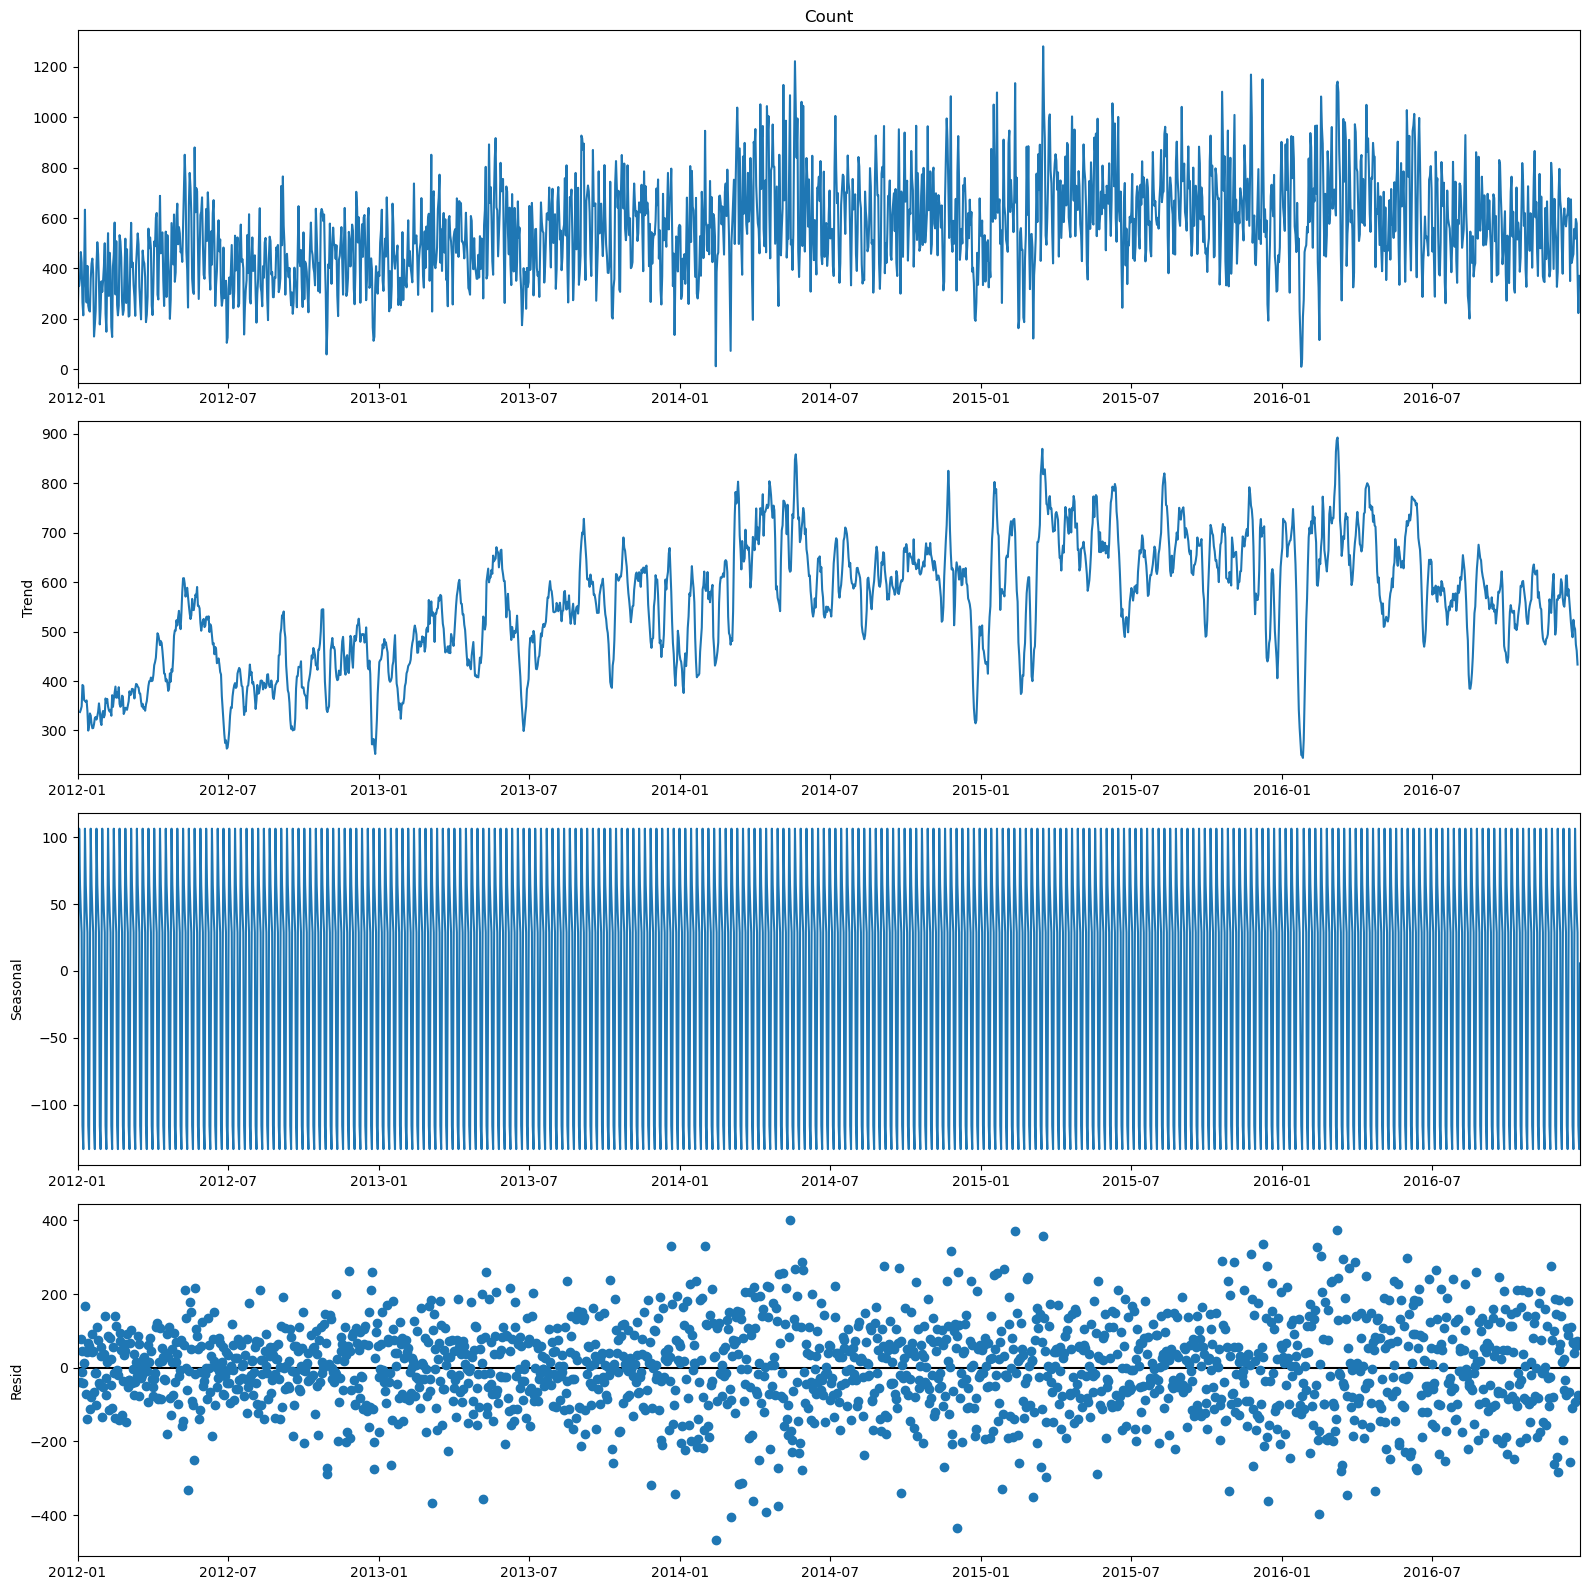

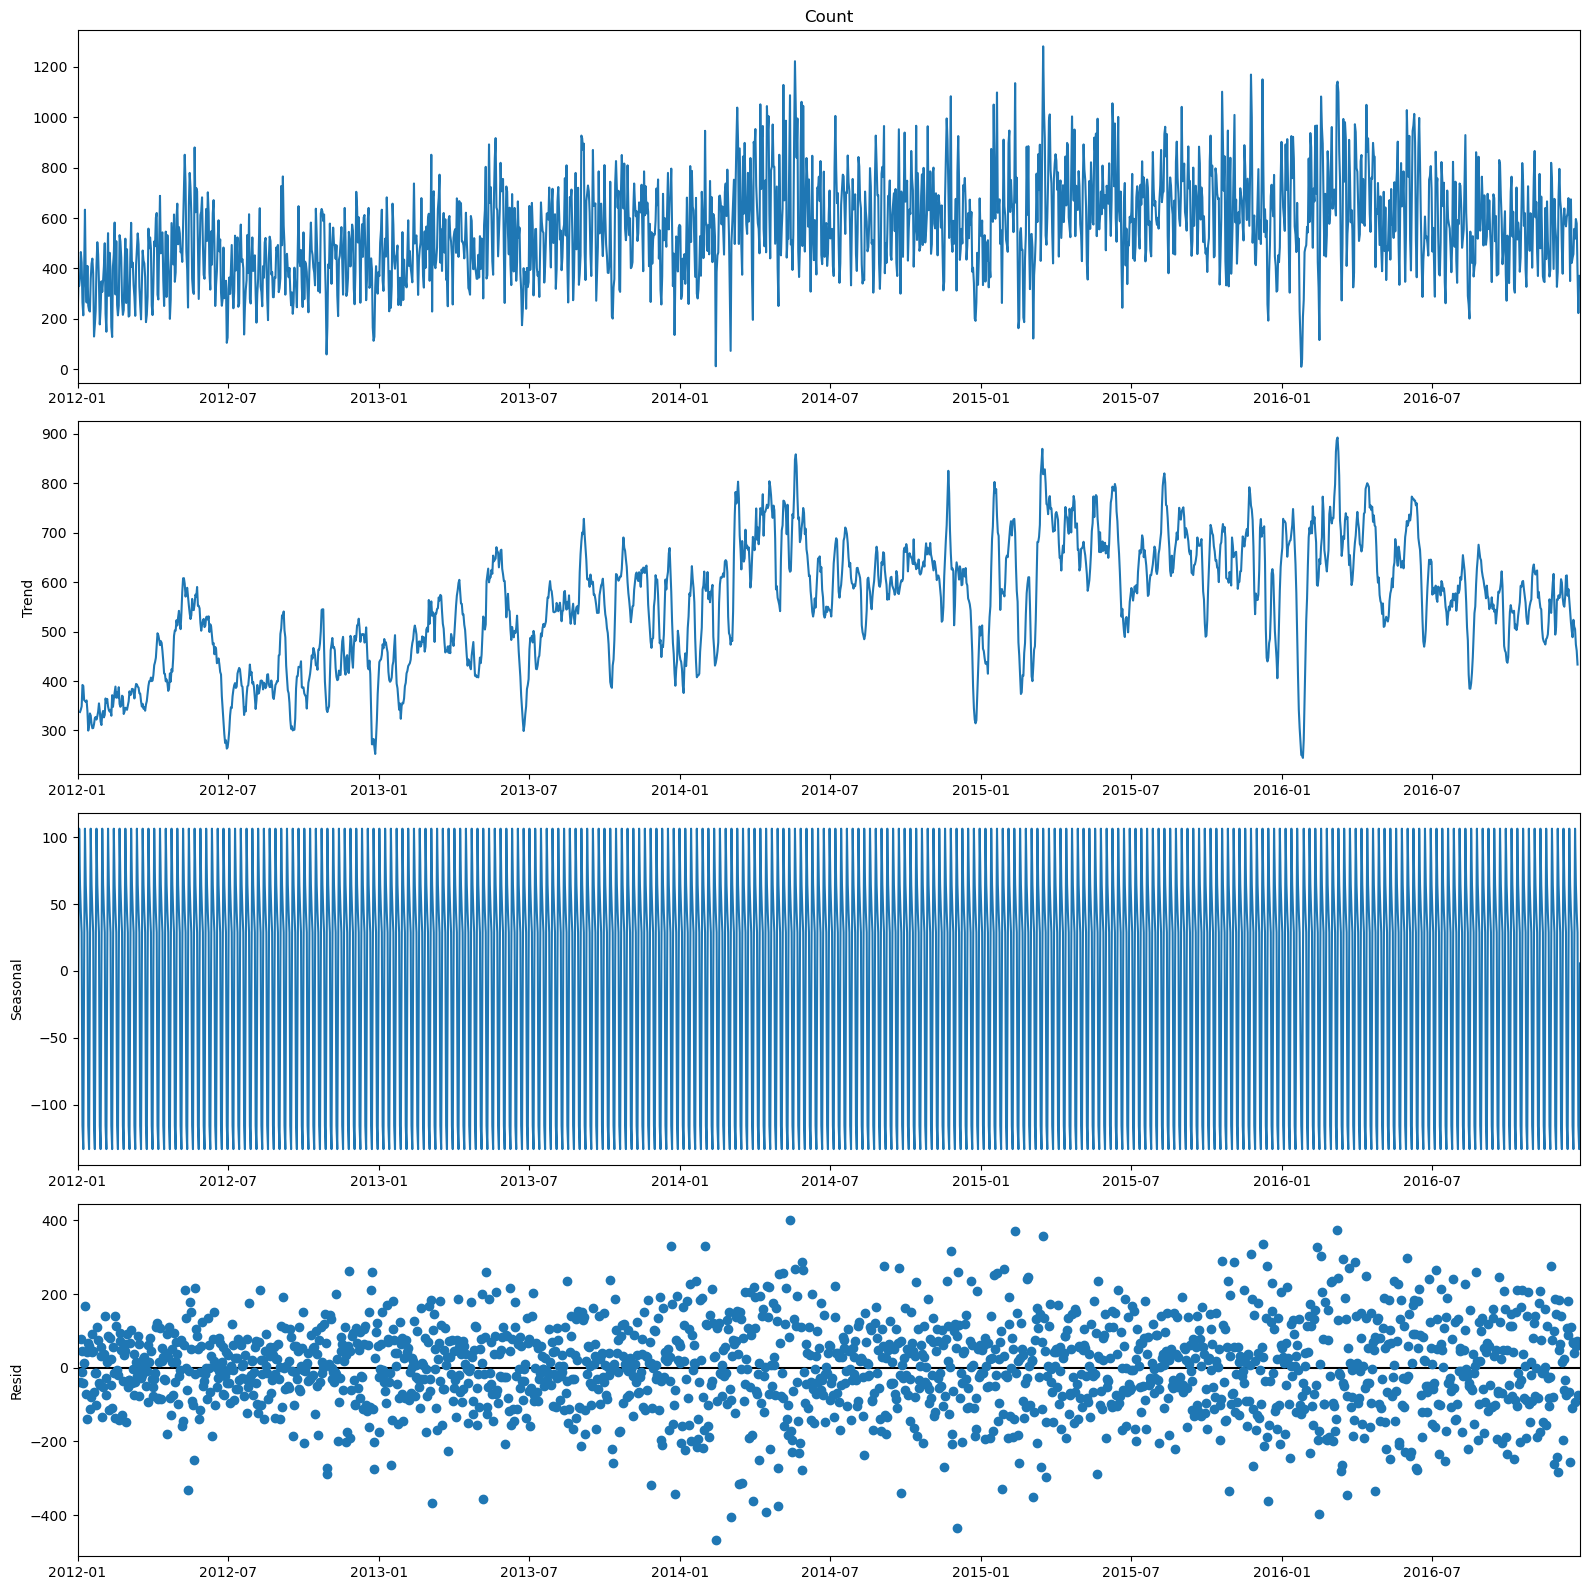

In [23]:
period= 7

matplotlib.rcParams['figure.figsize'] = [16,16]

addit = sm.tsa.seasonal_decompose(df, model='additive', period=period)
addit.plot()

#### Multiplicativo

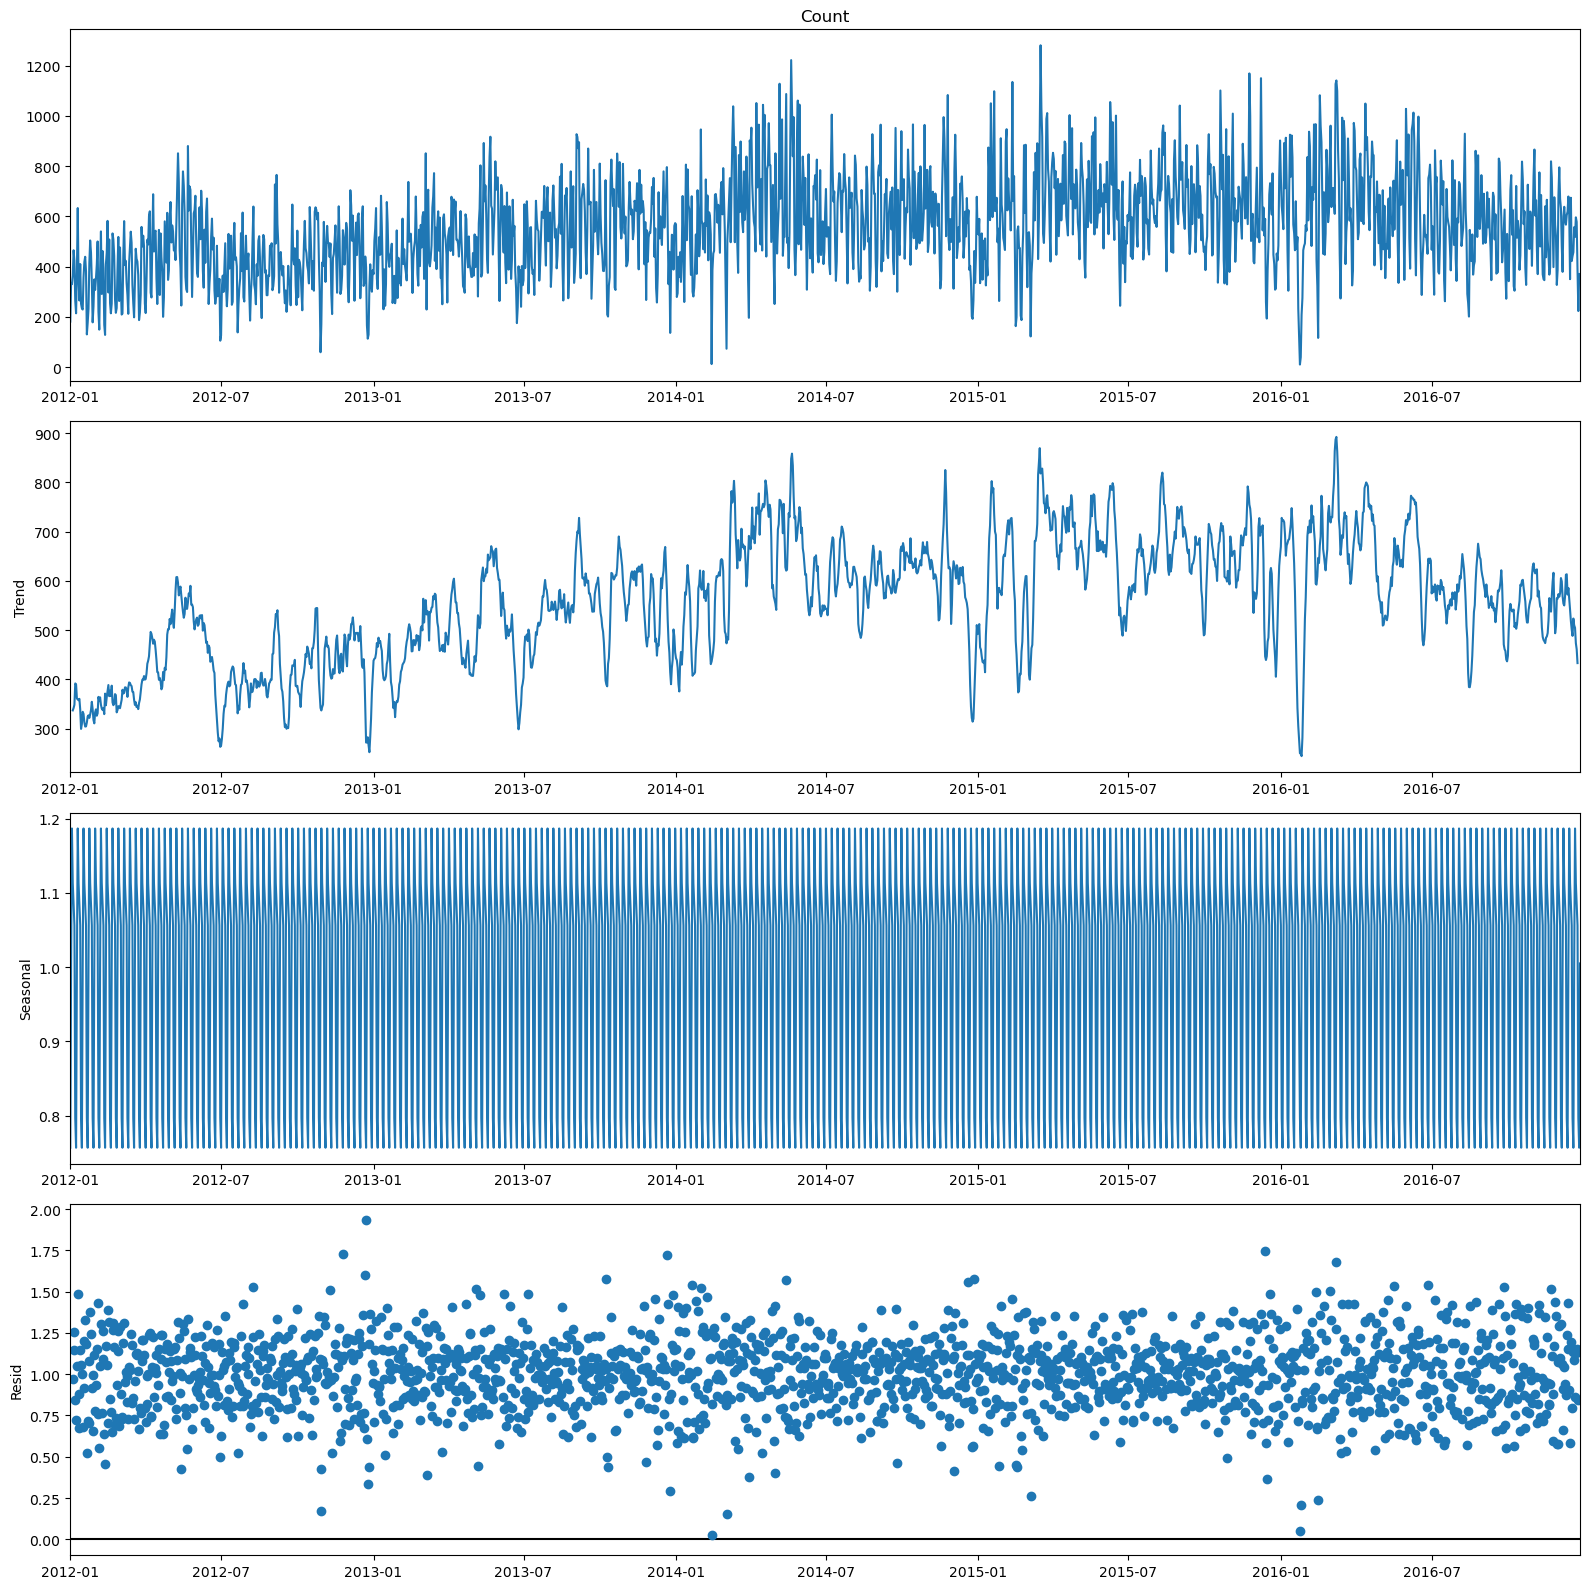

In [24]:
# Multiplicativod
mult = sm.tsa.seasonal_decompose(df, model='multiplicative', period=period)
mult.plot(); plt.show()

### Extraer la tendencia y ajustar un modelo deterministico. 
- Explicar su relacion con el contexto.
- Obtener conclusiones acerca de la validez del modelo.

#### Tendencia

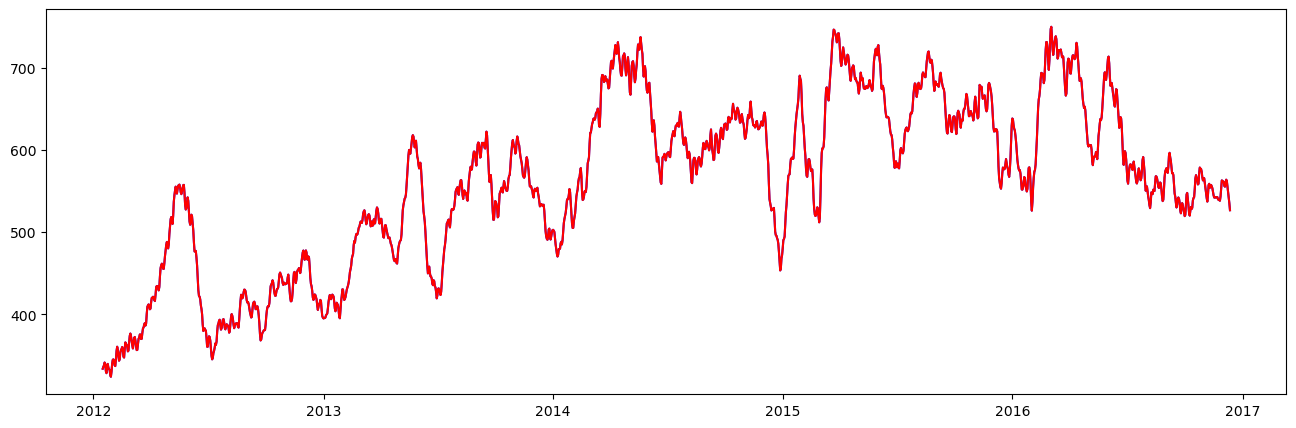

In [25]:
matplotlib.rcParams['figure.figsize'] = [16,5]
period=30
addit = sm.tsa.seasonal_decompose(df, model='additive', period=period)
mult = sm.tsa.seasonal_decompose(df, model='multiplicative', period=period)
plt.plot(addit.trend, color="blue")
plt.plot(mult.trend, color="red")
plt.show()

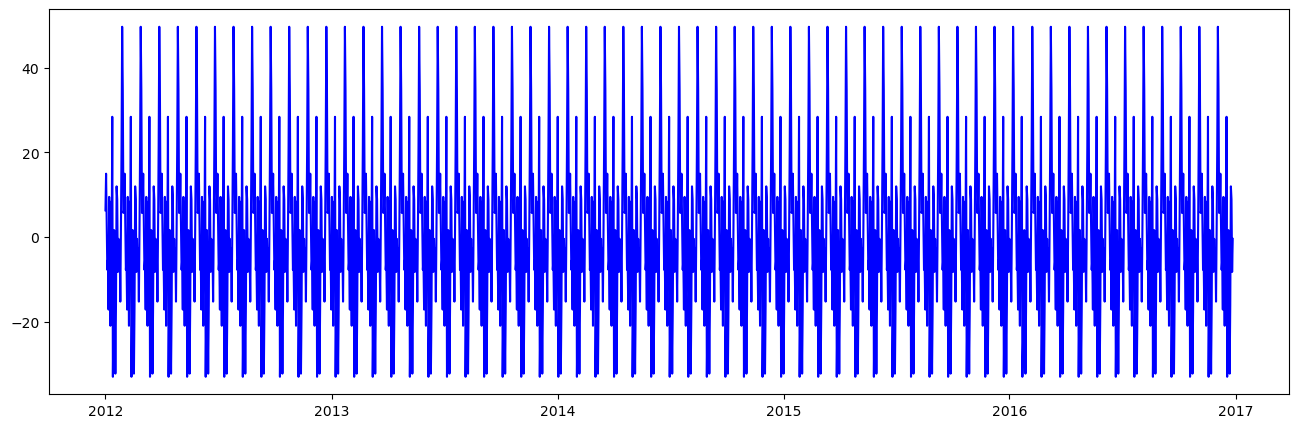

In [26]:
matplotlib.rcParams['figure.figsize'] = [16,5]
period=30
addit = sm.tsa.seasonal_decompose(df, model='additive', period=period)
mult = sm.tsa.seasonal_decompose(df, model='multiplicative', period=period)
plt.plot(addit.seasonal, color="blue")
plt.show()

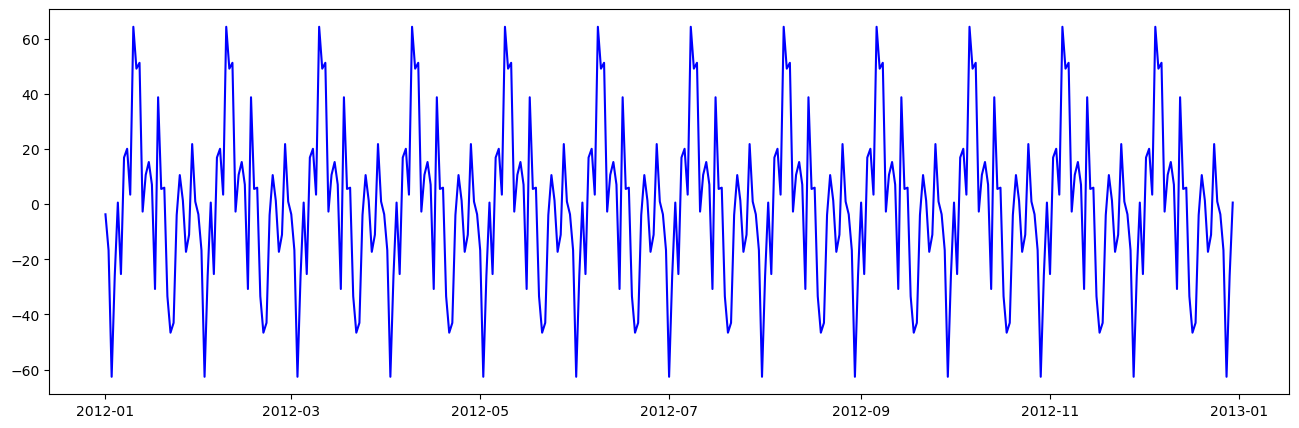

In [27]:
matplotlib.rcParams['figure.figsize'] = [16,5]
period=30
addit = sm.tsa.seasonal_decompose(df[:365], model='additive', period=period)
mult = sm.tsa.seasonal_decompose(df, model='multiplicative', period=period)
plt.plot(addit.seasonal, color="blue")
plt.show()

### CONCLUSION

Al ver la descomposición de la serie, se puede observar una tendencia anual pero que aumenta considerablemente a través de los años, pero que en el año 2016 comienza un descenso. En principio el aumento de que se puede notar en los años 2012 - 2013 - 2014 - 2015 se puede deber al incremento de autos en la ciudad. Para el año 2016 se podria decir o bien que ha sucedido un hecho aislado o bien que se incrementaron los controles sobre los automoviles que hace que descienda la cantidad de multas. Por otro lado, se puede observar cierta estacionalidad a pesar de ver algo de ruido si analizamos un año. 

### Ajustar un modelo deterministico

#### Ajustando un modelo deterministico ciclico

In [28]:

sig = df.reset_index().Count
sig = sig.drop([1820, 1821])
N = 364  # days
sample = 2 # years

dataframe = pd.Series(sig)
print(dataframe)
ts = pd.DataFrame(dataframe.values)
rows = int(len(ts)/N)
print(rows)
data = ts.values.reshape(rows, N)
betas = data.mean(axis=0)
est = np.tile(betas,rows)

0       181
1       334
2       330
3       364
4       465
       ... 
1815    518
1816    596
1817    578
1818    387
1819    223
Name: Count, Length: 1820, dtype: int64
5


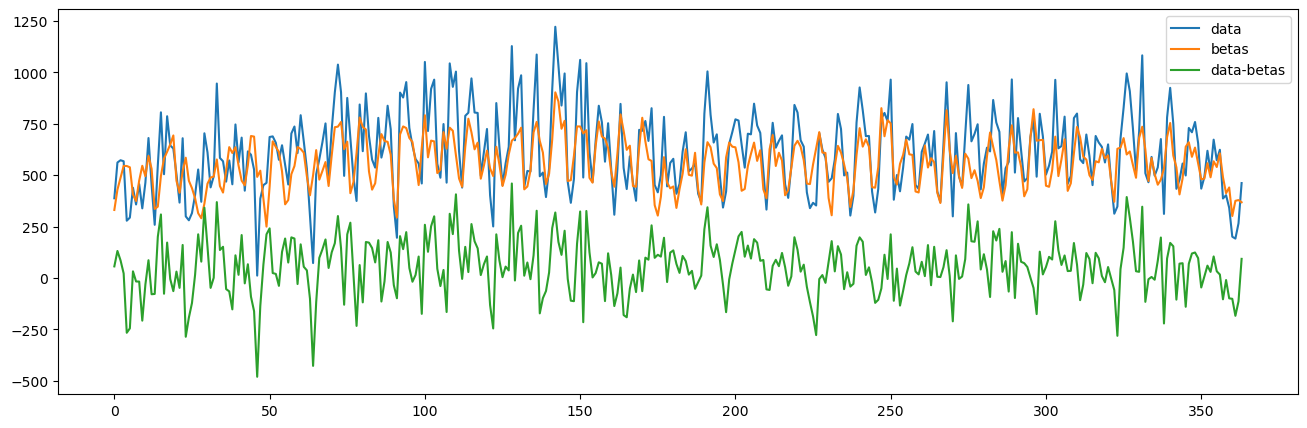

In [29]:
plt.plot(data[sample,:])
plt.plot(betas)
plt.plot(data[sample,:]-betas)
plt.legend(['data','betas','data-betas'])
plt.show()

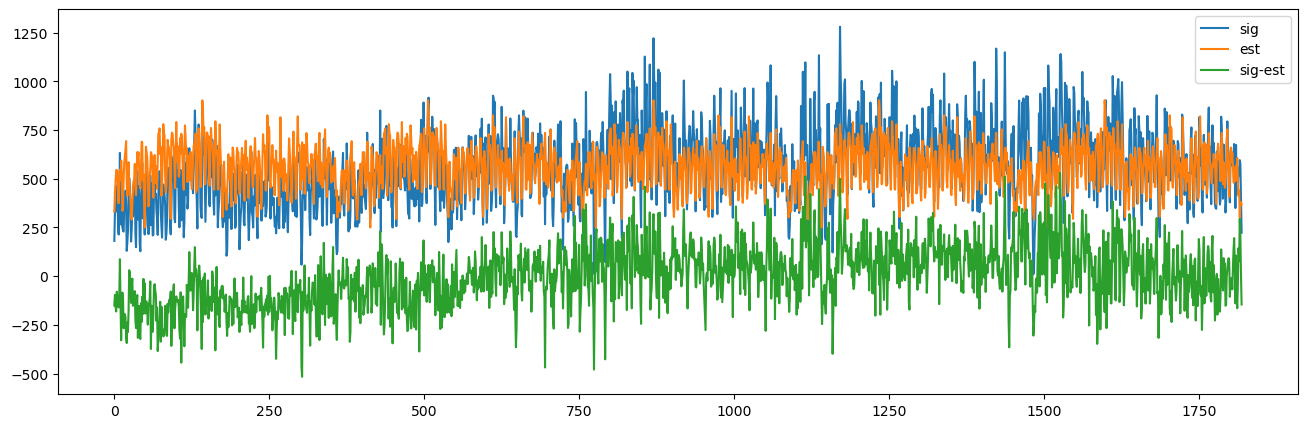

In [30]:
plt.plot(sig)
plt.plot(est)
plt.plot(sig-est)
plt.legend(['sig','est','sig-est'])
# plt.legend(['sig','est'])
plt.show()

### CONCLUSION

Como pudimos observar anteriormente, se veian un comportamiento ciclico anual, por lo cual, con un N de 365 dias, se ajusta bien al modelo. 

### Ajuste de modelo con polyfit

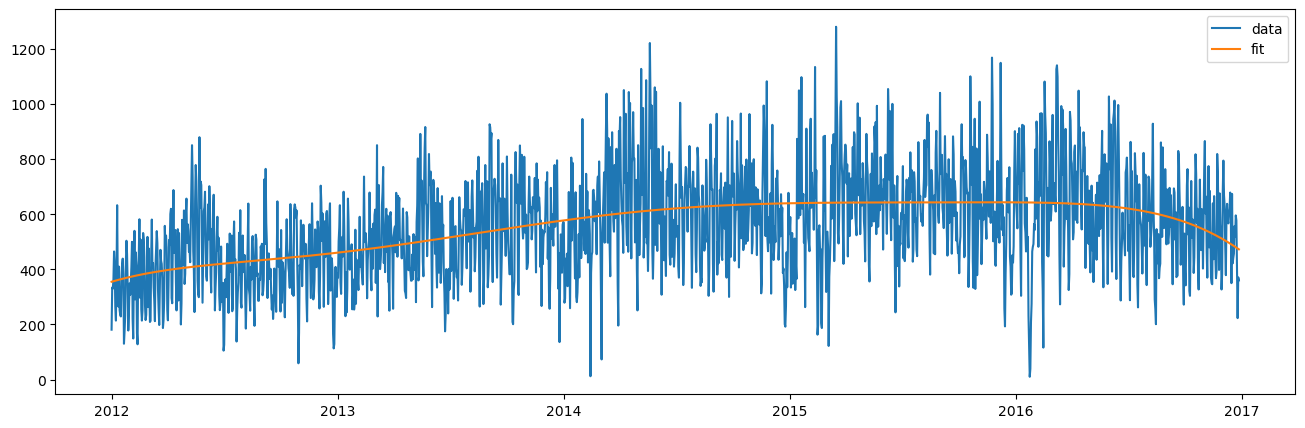

In [31]:
x = mdates.date2num(df.index)
f = 1/4

poly = np.polyfit(x, df, deg=6)

fig, ax = plt.subplots()
ax.plot(df, label='data')
ax.plot(df.index, np.polyval(poly, x), label='fit')
ax.legend()

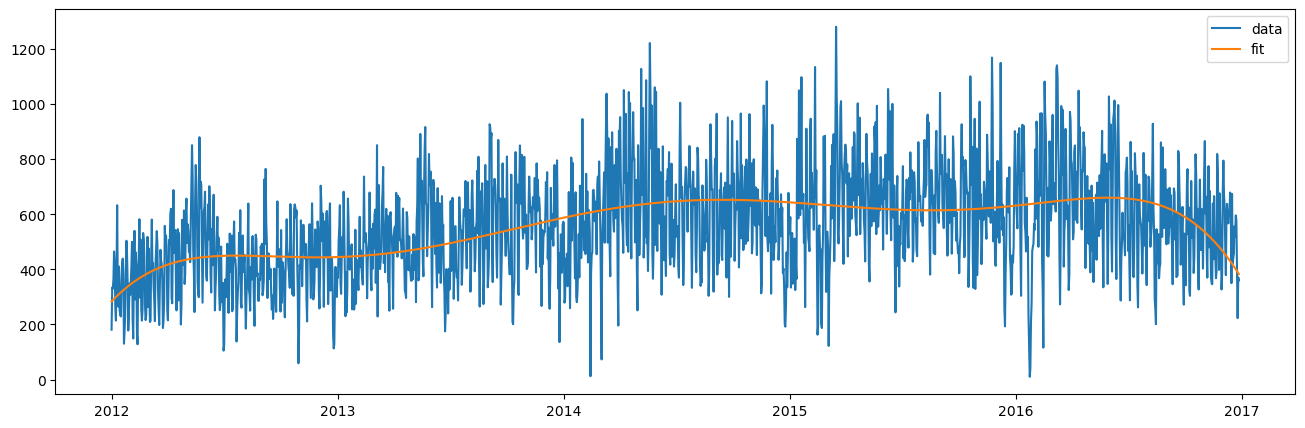

In [32]:
def objective(x, a, b, c, d, e, f, g):
    return a * x**6 + b * x**5 + c * x**4 + d * x**3 + e * x**2 + f * x + g

x = mdates.date2num(df.index)
popt, _ = curve_fit(objective, x, df)

a, b, c, d, e, f, g = popt

y_line = objective(x, a, b, c, d, e, f, g)

fig, ax = plt.subplots()
plt.plot(df, label="data")
plt.plot(df.index, y_line, label="fit")
ax.legend()

#### CONCLUSION

Con el ajuste de un modelo polinomico, se ve que se ajusta como si seria la media, por lo que no se aprecian los ciclos marcados como se esperaba observar.